In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow

In [2]:
data = pd.read_csv('SPY.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,26.079659,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,26.265144,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.320782,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.599014,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.710312,531500
...,...,...,...,...,...,...,...
7010,2020-11-30,362.829987,363.119995,359.170013,362.059998,362.059998,83872700
7011,2020-12-01,365.570007,367.679993,364.929993,366.019989,366.019989,74505000
7012,2020-12-02,364.820007,366.959991,364.200012,366.790009,366.790009,45927000
7013,2020-12-03,366.679993,368.190002,365.500000,366.690002,366.690002,62882000


<h1> Train Test Splitter </h1>

In [3]:
def input_label_splitter(window_size, input_data):
    n = len(input_data)    
    train_inputs = []
    train_labels = []
    for i in range(61, n-1):
        train_inputs.append(input_data[i-window_size:i])
        train_labels.append(input_data[i])
    return np.array(train_inputs), np.array(train_labels)

<h1> Normalizing the closing prices </h1>

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
close_scaled = sc.fit_transform(np.array(data['Close']).reshape(-1, 1))

In [5]:
from sklearn.model_selection import train_test_split
X, y = input_label_splitter(20, close_scaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False, random_state = False)

<h1> LSTM fed on Closing Prices </h1>

In [38]:
class LSTM_Model(keras.Model):    
    def __init__(self, optimizer, inp_shape):
        super(LSTM_Model, self).__init__()
                
        self.optimizer = optimizer

        #1st Convolution Layer
        self.LSTM1 = LSTM(units = 50, return_sequences = False, input_shape = inp_shape)
        self.Dropout1 = Dropout(0.2)      
        
        self.Output = Dense(units = 1)
        
    def call(self, inputs):         
        y = self.LSTM1(inputs)        
        y = self.Dropout1(y)
    
        y = self.Output(y)
        return y

In [39]:
LSTM_Model_1 = LSTM_Model(keras.optimizers.Adam(learning_rate=  0.00001), (X_train.shape[1], 1))
LSTM_Model_1.build((None, X_train.shape[1], 1))
LSTM_Model_1.summary()
LSTM_Model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = LSTM_Model_1.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), batch_size = 32)

Model: "lstm__model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                multiple                  10400     
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
196/196 [==============================] - 4s 10ms/step - loss: 0.0190 - val_loss: 0.0089
Epoch 2/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 3/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 4/20
196/196 [==============================] - 1s 7ms/step - loss: 9.93

In [40]:
y_true = y_test
y_pred = LSTM_Model_1.predict(X_test)
y_pred.shape

(696, 1)

<IPython.core.display.Javascript object>


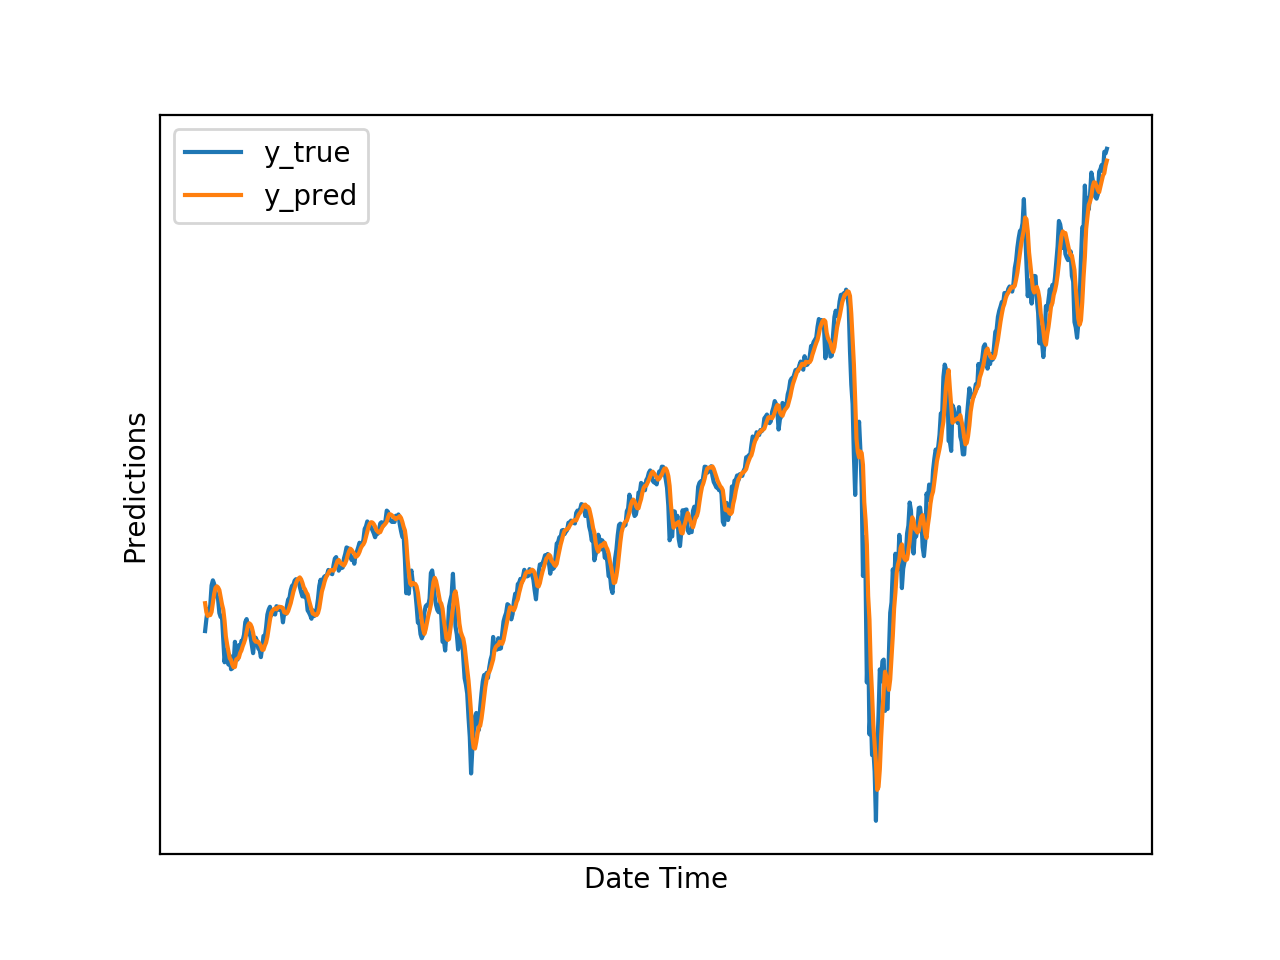

In [43]:
%matplotlib notebook
plt.plot(range(0,696), y_true, label = 'y_true')
plt.plot(range(0,696), y_pred, label = 'y_pred')
plt.xlabel('Date Time')
plt.xticks([])
plt.yticks([])

plt.ylabel('Predictions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


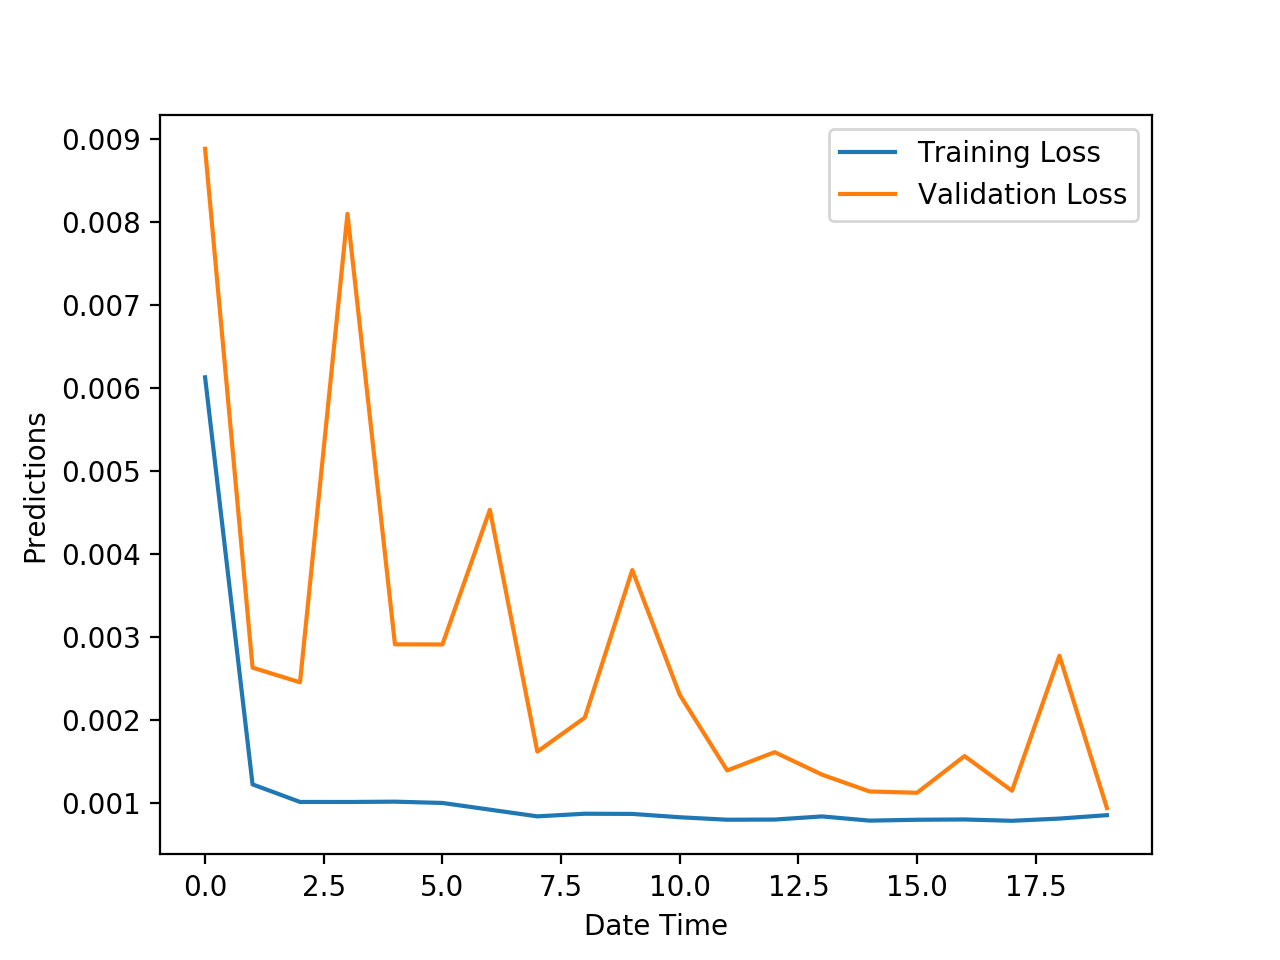

In [44]:
%matplotlib notebook
plt.plot(range(0,len(history.history['loss'])), history.history['loss'], label = 'Training Loss')
plt.plot(range(0,len(history.history['loss'])), history.history['val_loss'] , label = 'Validation Loss')
plt.xlabel('Date Time')
plt.ylabel('Predictions')
plt.legend()
plt.show()

<h1> Stacked LSTMS fed on Closing Prices </h1>

In [57]:
class LSTM_Model(keras.Model):    
    def __init__(self, optimizer, inp_shape):
        super(LSTM_Model, self).__init__()
                
        self.optimizer = optimizer

        #1st Convolution Layer
        self.LSTM1 = LSTM(units = 50, return_sequences = True, input_shape = inp_shape)
        self.Dropout1 = Dropout(0.2)      
        
        self.LSTM2 = LSTM(units = 50, return_sequences = False)
        self.Dropout2 = Dropout(0.4)    
        
        self.Output = Dense(units = 1)
        
    def call(self, inputs):         
        y = self.LSTM1(inputs)        
        y = self.Dropout1(y)
        
        y = self.LSTM2(y)
        y = self.Dropout2(y)
        
        y = self.Output(y)
        return y

In [58]:
LSTM_Model_2 = LSTM_Model(keras.optimizers.Adam(learning_rate=  0.00001), (X_train.shape[1], 1))
LSTM_Model_2.build((None, X_train.shape[1], 1))
LSTM_Model_2.summary()
LSTM_Model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = LSTM_Model_2.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), batch_size = 32)

Model: "lstm__model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               multiple                  10400     
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_12 (LSTM)               multiple                  20200     
_________________________________________________________________
dropout_12 (Dropout)         multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
196/196 [==============================] - 7s 16ms/step - loss: 0.0195 - val_loss: 0.0063
Epoch 2/20
196

In [76]:
y_true = y_test
y_pred = LSTM_Model_1.predict(X_test)
y_pred.shape

(696, 1)

<IPython.core.display.Javascript object>


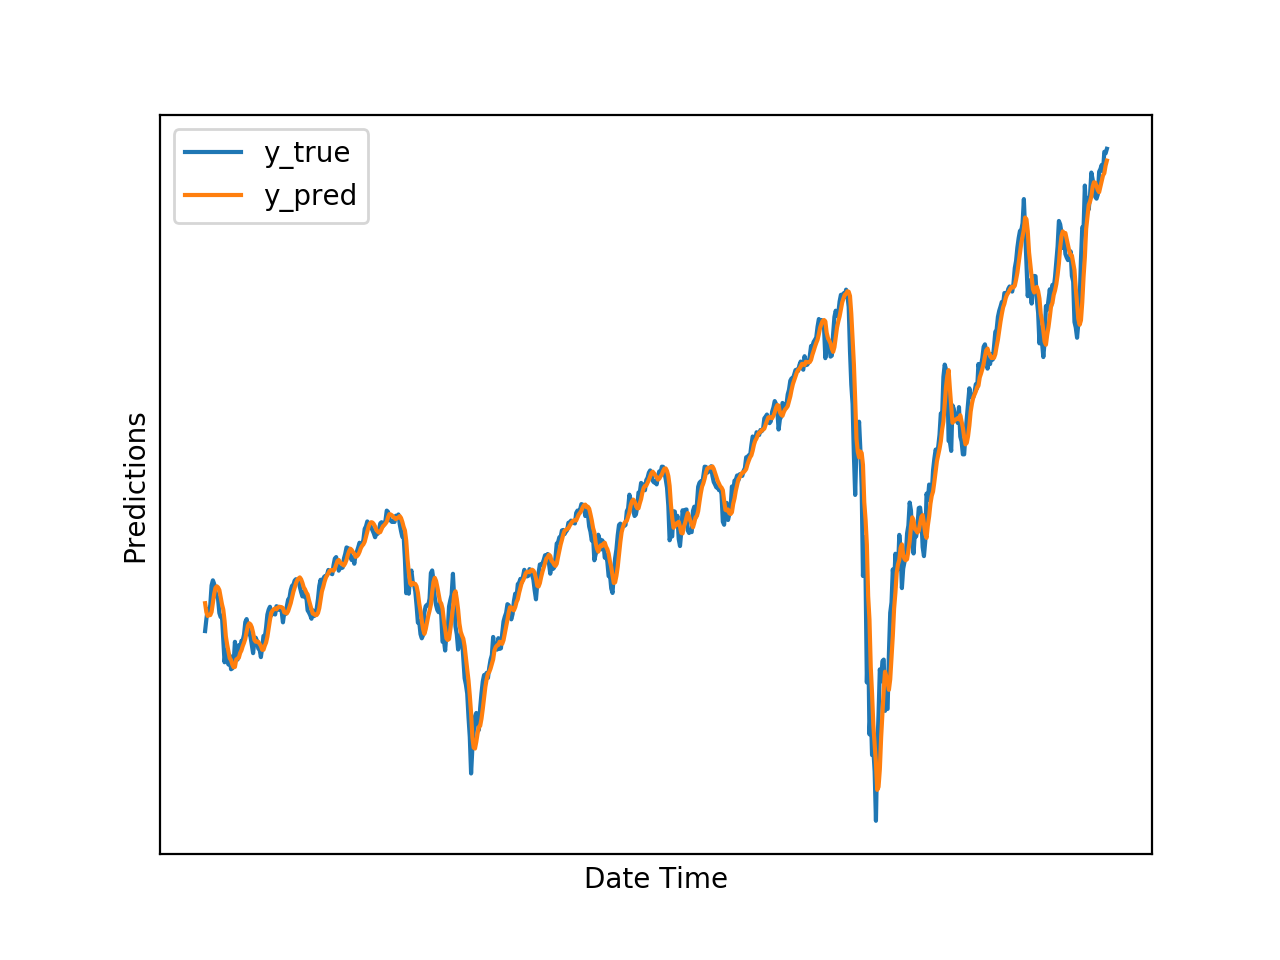

In [77]:
%matplotlib notebook
plt.plot(range(0,696), y_true, label = 'y_true')
plt.plot(range(0,696), y_pred, label = 'y_pred')
plt.xlabel('Date Time')
plt.xticks([])
plt.yticks([])

plt.ylabel('Predictions')
plt.legend()
plt.show()

In [61]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

<IPython.core.display.Javascript object>


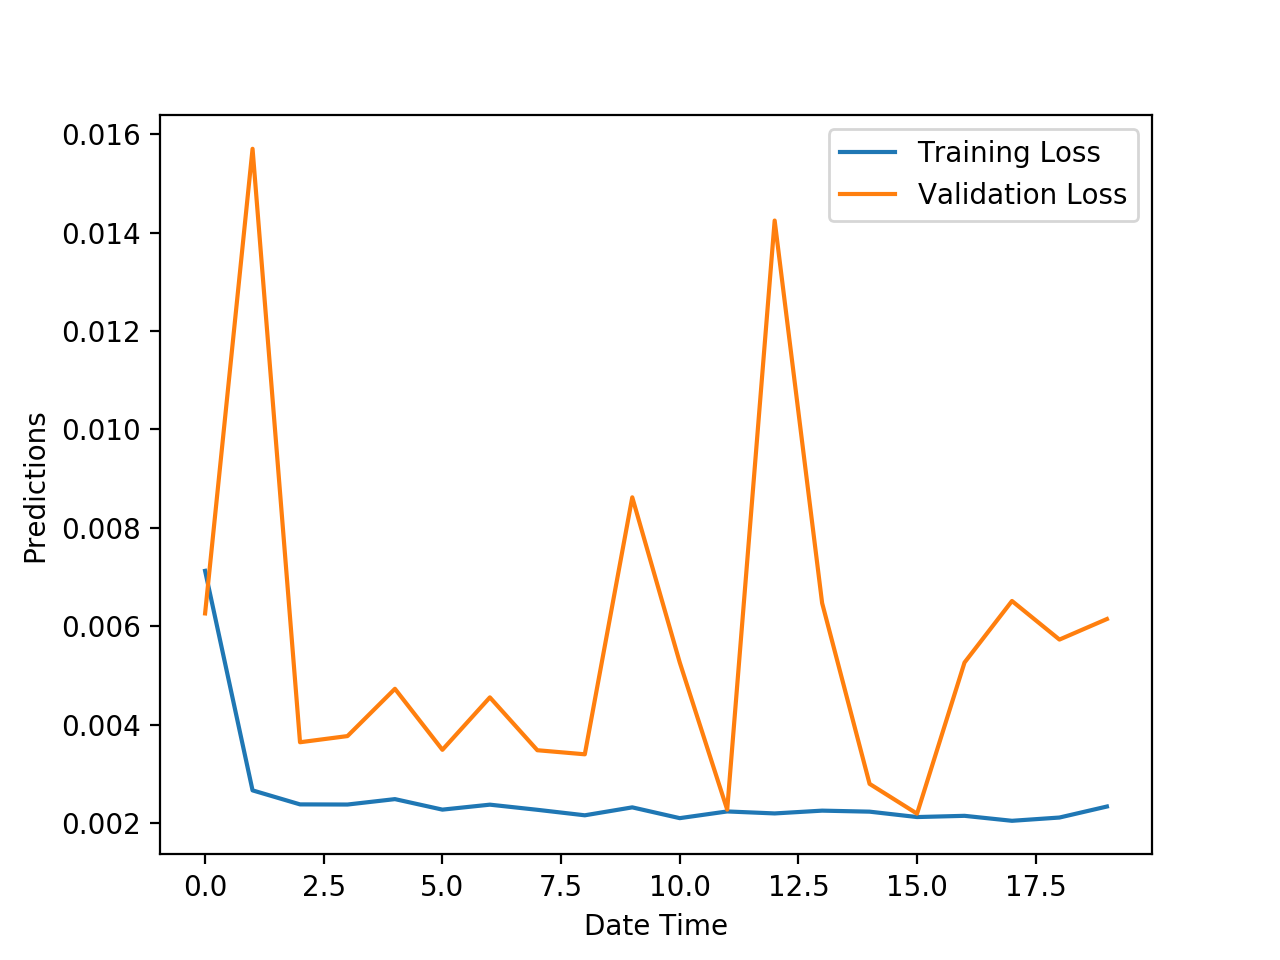

In [62]:
%matplotlib notebook
plt.plot(range(0,len(history.history['loss'])), history.history['loss'], label = 'Training Loss')
plt.plot(range(0,len(history.history['loss'])), history.history['val_loss'] , label = 'Validation Loss')
plt.xlabel('Date Time')
plt.ylabel('Predictions')
plt.legend()
plt.show()

<h1> Normalizing all the features

In [64]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data[data.columns[1:]])

<h1> Dimensionality Reduction </h1>

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(training_set_scaled)

PCA(n_components=1)

In [66]:
reduced_data = pca.transform(training_set_scaled)
pickle.dump(pca, open('pca-model' ,'wb'))

In [67]:
from sklearn.model_selection import train_test_split
X, y = input_label_splitter(20, reduced_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False, random_state = False)

<h1> Stacked LSTMS fed on data with reduced dimension </h1>

In [68]:
class LSTM_Model(keras.Model):    
    def __init__(self, optimizer, inp_shape):
        super(LSTM_Model, self).__init__()
                
        self.optimizer = optimizer

        #1st Convolution Layer
        self.LSTM1 = LSTM(units = 50, return_sequences = True, input_shape = inp_shape)
        self.Dropout1 = Dropout(0.2)      
        
        self.LSTM2 = LSTM(units = 50, return_sequences = False)
        self.Dropout2 = Dropout(0.4)    

        self.Output = Dense(units = 1)
        
    def call(self, inputs):         
        y = self.LSTM1(inputs)        
        y = self.Dropout1(y)
        
        y = self.LSTM2(y)
        y = self.Dropout2(y)
        
        y = self.Output(y)
        return y

In [69]:
LSTM_Model_3 = LSTM_Model(keras.optimizers.Adam(learning_rate=  0.00001), (X_train.shape[1], 1))
LSTM_Model_3.build((None, X_train.shape[1], 1))
LSTM_Model_3.summary()
LSTM_Model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = LSTM_Model_3.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), batch_size = 32)

Model: "lstm__model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               multiple                  10400     
_________________________________________________________________
dropout_13 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_14 (LSTM)               multiple                  20200     
_________________________________________________________________
dropout_14 (Dropout)         multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
196/196 [==============================] - 7s 16ms/step - loss: 0.0181 - val_loss: 0.0095
Epoch 2/20
196

In [70]:
y_true = y_test
y_pred = LSTM_Model_3.predict(X_test)

<IPython.core.display.Javascript object>


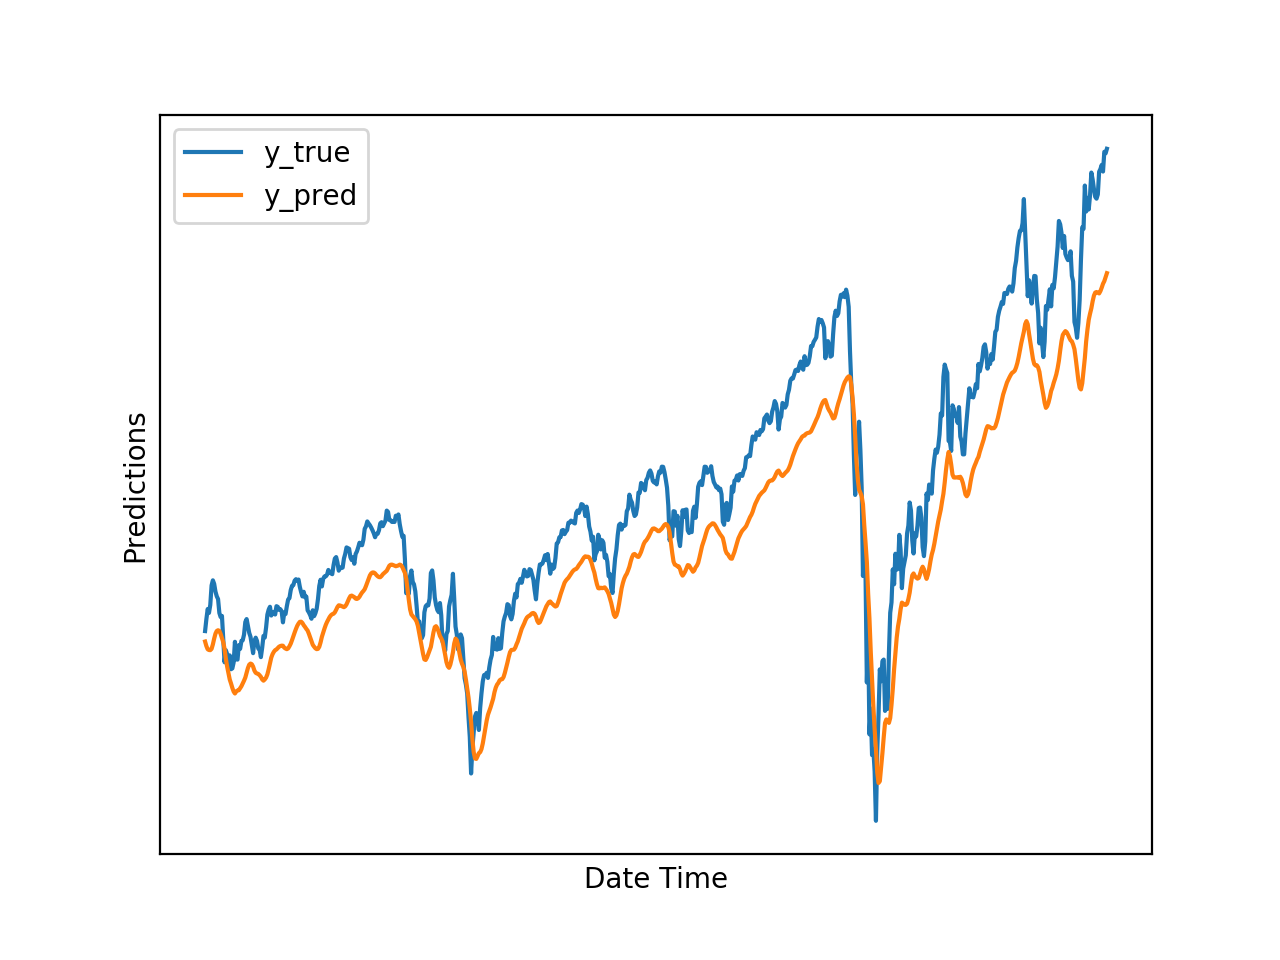

In [74]:
%matplotlib notebook
plt.plot(range(0,696), y_true, label = 'y_true')
plt.plot(range(0,696), y_pred, label = 'y_pred')
plt.xlabel('Date Time')
plt.xticks([])
plt.yticks([])

plt.ylabel('Predictions')
plt.legend()
plt.show()

In [72]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

<IPython.core.display.Javascript object>


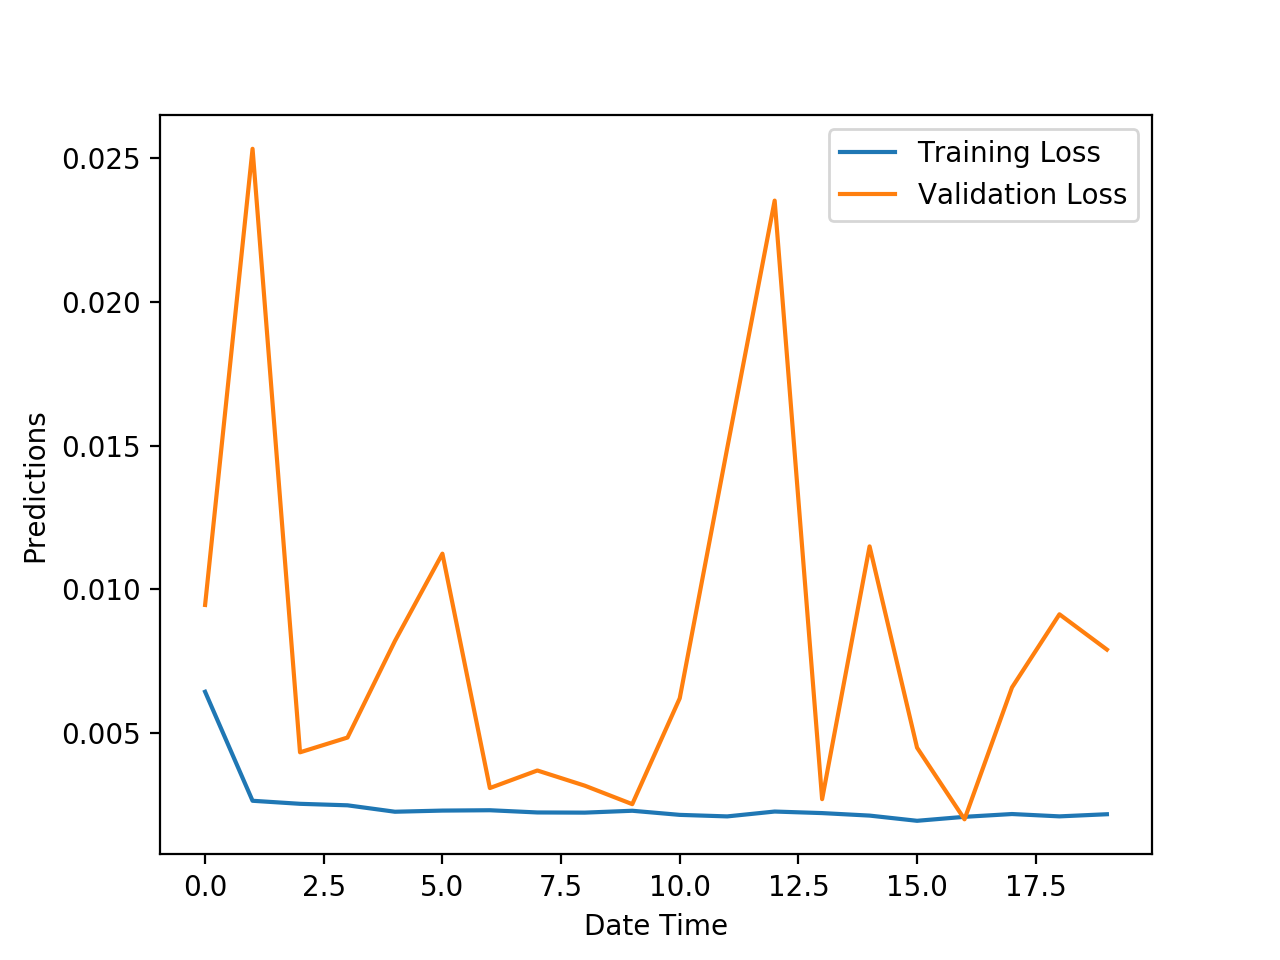

In [73]:
%matplotlib notebook
plt.plot(range(0,len(history.history['loss'])), history.history['loss'], label = 'Training Loss')
plt.plot(range(0,len(history.history['loss'])), history.history['val_loss'] , label = 'Validation Loss')
plt.xlabel('Date Time')

plt.ylabel('Predictions')
plt.legend()
plt.show()